# Python CCD Data Reduction
---

### Names: Solutions


This notebook walks through the basics of CCD data reduction within python. More detailed instructions (involving more powerful pieces of software) can be found in the CCD Data Reduction Guide written by Matt Craig and Lauren Chambers [https://mwcraig.github.io/ccd-as-book/00-00-Preface](https://mwcraig.github.io/ccd-as-book/00-00-Preface), which itself is based on the [IRAF CCD reduction](http://ircamera.as.arizona.edu/Astr_518/irafguid.pdf) and [stellar photometry](https://www.mn.uio.no/astro/english/services/it/help/visualization/iraf/daophot2.pdf) guides by Phil Massey. 

---
####  Previous Code
This section is a quick recap of the code that you have seen in the previous two labs.

*Load in an external package*

`import numpy as np`

*Define a function with one required input and one optional input (the optional input has a default value)*

`
def myfunc(variable1, variable2='Something'):
    return variable1
`

*Square root*

`np.sqrt(3.5)`

*Cosine*

`np.cos(1.2)`

*Convert from degrees to radians*

`np.radians(70)`

*Read in data from a file into an array:*

*Read in everything as a float*

`data = np.loadtxt('myfile.txt')`

*Read in everything as a string*

`data = np.loadtxt('myfile.txt',dtype=str)`

*Read in everything as a string, and skip the first row*

`data = np.loadtxt('myfile.txt',dtype=str,skiprows=1)`

*Read in everything as a string, skip the first row, and skip rows that start with ':'*

`data = np.loadtxt('myfile.txt',dtype=str,skirows=1,comments=':')`

*Read in everything as a string, skip the first row, skip rows that start with ':', and the columns are separated by commas*

`data = np.loadtxt('myfile.txt',dtype=str,skiprows=1,comments=':',delimiter=',')`


*Convert from string to a float*

`x = float(mystring)`

*For loop:*

`
for i in range(10):
    print(i)
`

*For loop, over elements in a list*

`
for element in mylist:
    print(element)
`

*If statement*

`
if x>5:
    print(x)
`

*Access a certain column/row in a two-dimensional array*

`
fifth_column = data[:,4]
third_row = data[2,:]
entry1 = data[1,3] #value from the 2nd row and the fourth column
`

*Slicing through an array*

`slice = myarray[2:5] # selects elements at position 2, 3, and 4 from a one dimensional array`

*Create an empty list*

`mylist = []`

*Append items to a list*

`mylist.append(newvalue)`

*Return the length of a list*

`len(mylist)`

*Take the average of a list (assuming they are floats) or an array*

`np.mean(mylist)`


*Plot data points* 

`
import matplotlib.pyplot as plt
plt.plot(x,y,marker='o',color='k',linestyle='')
`

*Add a label to the X-axis*

`plt.xlabel('My X-axis')`

*Add a label to the Y-axis*

`plt.ylabel('My Y-axis')`

*Add a title*

`plt.title('My Title)'`

*Add a vertical line*

`plt.axvline(vertical_value)`

*Add a horizontal line*

`plt.axhline(horizontal_value)`


#### New Code:

This lab will introduce a number of different pieces of code, including code that can:

- *Open a fits file*
- *Get info on the fits file*
- *Read the data from a fits file into a variable*
- *Read the header from a fits file into a variable*
- *Access elements of the header*
- *Output the shape of a numpy array*
- *Display an image using the show_image function*
- *Plot a histogram*
- *`plt.xlim(value1,value2)`*
- *Close a fits file*
- *`np.zeros((dimension1,dimension2))`*
- `enumerate(mylist)`
- *Take the median along one dimension of a multi-dimensional array*
- *Just read in the header*
- *Add a new element to the header*
- *Create a new fits file*
- *Write out a fits file*

---

### Reducing CCD Data

Any data taken at an observatory must go through a number of steps before it can be used for scientific analysis. This includes correcting for the bias level, the dark current, and inhomogeneities in the sensitivity across the detector. These contributions can be accounted for with the use of bias frames, dark frames, and flat field images. *Bias frames* are images with an exposure time of zero, and represent the number of counts that each pixel starts with  before any contribution from the sky, or other sources of electrons. *Dark frames* represent the contribution from the thermal electrons; they are matched to the exposure time of the science image since the thermal signal increases with time. *Flat field frames* are images of a uniformly illuminated object. Any differences in the recorded signal between different pixels in a flat field image are most likely due to differences in the response rate of different pixels. 

Bias and dark frames are subtracted from the science image, while a normalized flat field frame is divided off to produce a processed image. The formula for constructing a useable science image from a raw image is:

$science = \frac{raw - bias - dark}{flat}$



In [1]:
# Load in the necessary packages
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

### Bias Frames (and basic fits handling in python)

First, lets read in a bias frame. A subset of the most recent set of calibration data taken at our observatory are located in the Cal_data folder, and we will look at the `CalR-0001Bias.fit` file (The rest of the calibration files are located on the Astro server in Shared/CCD_Data/2020/01_31_20/Calibration). 

We will use the `astropy` package, which includes the ability to read in fits files. Fits files are read into an HDUList object, which is a flexible data type that contains the data as well the header. [More info about fits files in python can be found on the [astropy.io.fits documentation page.](https://docs.astropy.org/en/stable/io/fits/)] 

Below, after reading in the fits file into the variable `bias1`, we use the `.info()` function to print information about the fits file.

In [2]:
from astropy.io import fits

# Read in a bias frame
bias1 = fits.open('Cal_data/CalR-0001Bias.fit')
bias1.info() #print basic info about the fits file

Filename: Cal_data/CalR-0001Bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1024, 1024)   int16 (rescales to uint16)   


The output of the `.info()` function says that this fits file has one extension (since there is only one line of output), and has dimensions 1024x1024. The data and header for this extension can be accessed using `.data` and `.header`, as shown below. If other extensions existed, they could be accessed in a similar manner, by simply changing the index. All of the files that you will look at today will only have one extension. 

In [3]:
bias_data = bias1[0].data
bias_header = bias1[0].header

The header is a dictionary and individual elements, such as the image type and the exposure time, can be accessed as with dictionaries. We can print off all of the keys to see what they are.

In [4]:
print('Image Type: {}'.format(bias_header['imagetyp'])) #Image type header keyword
print('Exposure Time: {}'.format(bias_header['exptime'])) #Exposure time image keyword
print('---')
for key in bias_header.keys():
    print(key) #Print out the keys

Image Type: Bias Frame
Exposure Time: 0.0
---
SIMPLE
BITPIX
NAXIS
NAXIS1
NAXIS2
BSCALE
BZERO
DATE-OBS
EXPTIME
EXPOSURE
SET-TEMP
CCD-TEMP
XPIXSZ
YPIXSZ
XBINNING
YBINNING
XORGSUBF
YORGSUBF
READOUTM
IMAGETYP
FOCALLEN
APTDIA
APTAREA
SBSTDVER
SWCREATE
SWSERIAL
SITELAT
SITELONG
JD
OBJECT
TELESCOP
INSTRUME
OBSERVER
NOTES
FLIPSTAT
SWOWNER


The data themselves are a numpy array, and the flux in individual pixels can be accessed in the same way as with any two-dimensional array. As we saw based on the result from the `.info()` function the data has dimensions 1024x1024. We can verify these dimensions by looking at the `shape` of the array.

In [5]:
print('Shape of the array: {}'.format(bias_data.shape))

Shape of the array: (1024, 1024)


Since it is a regular numpy array, we can access the flux values at various locations

In [6]:
print('Flux in corner element {}'.format(bias_data[0,0]))

Flux in corner element 1679


> **Q:** Modify the following code to print out the flux in the central pixel, and the average of the flux in the fifth column.

In [7]:
print('Flux in center element {}'.format(bias_data[512,512])) # <- replace x with the appropriate code
print('Average flux in fifth column {}'.format(np.mean(bias_data[:,4]))) # <- replace x with the appropriate code

Flux in center element 1495
Average flux in fifth column 1529.0107421875


The `convenience_functions.py` file contains a function called `show_image` that can help in displaying images. 

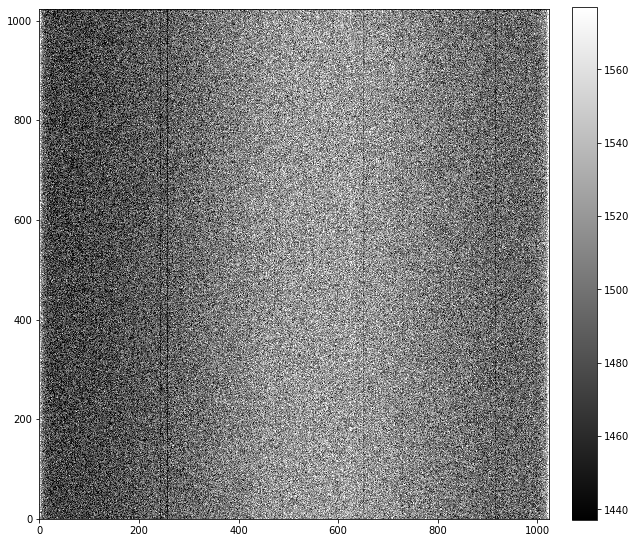

In [8]:
from convenience_functions import show_image
show_image(bias_data,cmap='gray')

As a bias frame, this image represents the state of the detector before it has been exposed to light. Variations in pixel value are partly due to read noise, as well as defects in the detector. We can look at the distribution of pixel values using the `hist` function from matplotlib (which we met in the first lab).

Text(0.5, 1.0, 'Distribution of Bias Counts')

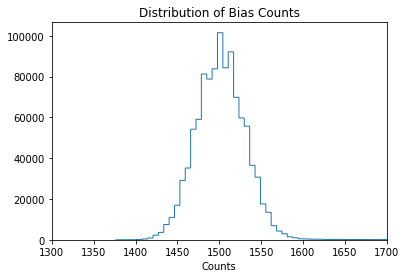

In [9]:
plt.hist(bias_data.flatten(),10000,histtype='step')
plt.xlim(1300,1700) # <-- What does this line do??
plt.xlabel('Counts')
plt.title('Distribution of Bias Counts')

>**Q:** To the above code block, add code to label the X-axis as 'Counts' and add the title 'Distribution of Bias Counts'.
>

> **Q:** What does the `plt.xlim(1300,1700)` line do? You can either look up the answer on the interwebs, use the help function to look at its docstring, or you can play around with the values to see what changes. 
>
> **A:** **It sets the range for the x-axis.**

### Dark Frames

Now lets look at a dark frame. 

> **Q:** As we did with the bias frame, read in the first dark frame (`CalR-0001Dark.fit`) from the `Cal_data` folder and display the image using the `show_image` function.

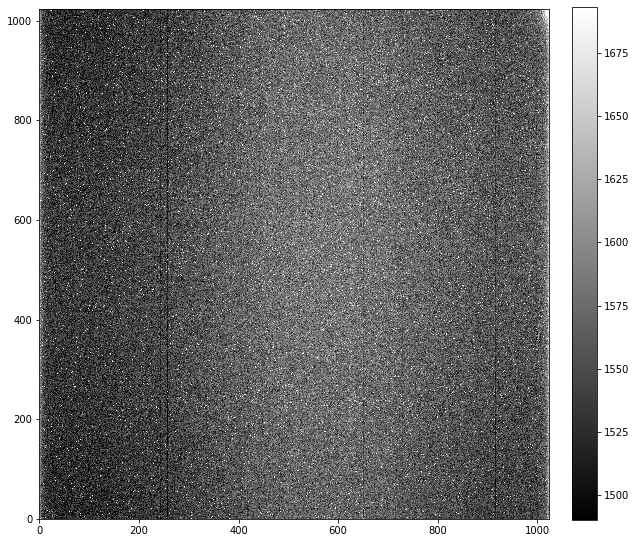

In [10]:
# Read in a dark frame, and display the image. 
dark = fits.open('Cal_data/CalR-0001Dark.fit')
dark_data = dark[0].data

show_image(dark_data,cmap='gray')

The dark frame represents the contribution from thermal electrons. The image was taken with the shutter closed and an exposure time of sixty seconds. The pixel values are only slightly higher than the bias frame, suggesting that the dark current is not very high. We can calculate the dark current by subtracting a bias image, and then dividing the result by the exposure time. 

> **Q:** The following function calculates the average dark current, in electrons per second, based on a given dark frame. *But there are errors and missing lines in the function.* Correct the errors and missing lines so that the function runs properly.

In [21]:
def calc_dark_current(dark_filename):
    dark_image = fits.open(dark_filename)#Insert code that reads the fits file dark_filename into the variable dark_image
    dark_data = dark_image[0].data
    dark_header = dark_image[0].header
    exp_time = dark_header['exptime']#Insert code that reads the exptime keyword from the header, places this value in the variable exp_time
    dark_image.close()
    gain = 2.
    avg_dark_current = gain*np.mean(dark_data)/exp_time #missing 'n' in 'mean'
    print('Average Dark current: {:0.2f} e-/sec'.format(avg_dark_current)) #avg_dark_current, not avg_current

calc_dark_current('Cal_Data/CalR-0001Dark.fit') #input to this function needs to be a string

Average Dark current: 52.13 e-/sec


### Flat Field

Now lets look at the flat field

> **Q:** As we did with the bias frame, read in the first flat field frame (`CalR-0001R.fit`) from the `Cal_data` folder. Display the image using the `show_image` function.

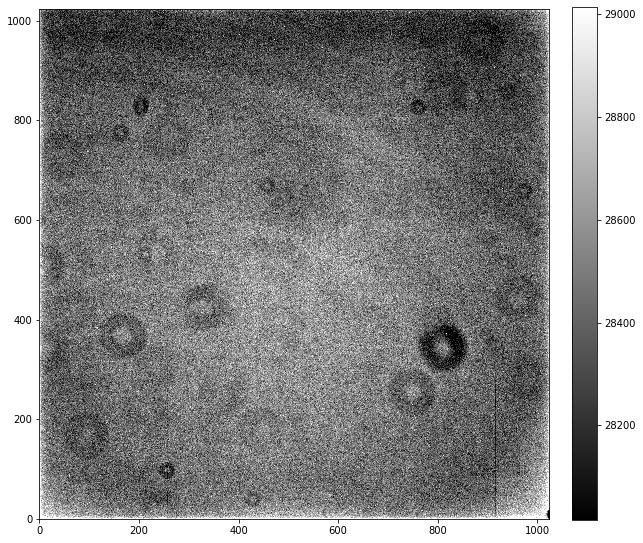

In [12]:
# Read in a flat field, and display the image. 
flat = fits.open('Cal_data/CalR-0001R.fit')
flat_data = flat[0].data

show_image(flat_data,cmap='gray')

### Reducing science data

A science image needs to be corrected for the dark, bias, and flat field. This can be done based on individual dark, bias and flat field images, but it is much better to combine multiple frames. This is because each frame contains read noise on the individual pixels. By averaging multiple frames we can reduce the contributions of this read noise. 

The following introduces how to combine multiple frames, and how to save the output. First we will set up a dictionary that contains the names of all of the calibration files. This includes the bias frames, the dark frames, and the flat field images for each filter. 

In [13]:
# Create a dictionary with the file names of the bias frames, dark frames, and flat field frames
data_files = {'biases': ['Cal_data/CalR-0001Bias.fit','Cal_data/CalR-0002Bias.fit','Cal_data/CalR-0003Bias.fit',
          'Cal_data/CalR-0004Bias.fit','Cal_data/CalR-0005Bias.fit','Cal_data/CalR-0006Bias.fit',
          'Cal_data/CalR-0007Bias.fit','Cal_data/CalR-0008Bias.fit','Cal_data/CalR-0009Bias.fit',
          'Cal_data/CalR-0010Bias.fit','Cal_data/CalV-0001Bias.fit','Cal_data/CalV-0002Bias.fit',
            'Cal_data/CalV-0003Bias.fit','Cal_data/CalV-0004Bias.fit','Cal_data/CalV-0005Bias.fit',
            'Cal_data/CalV-0006Bias.fit','Cal_data/CalV-0007Bias.fit','Cal_data/CalV-0008Bias.fit',
            'Cal_data/CalV-0009Bias.fit','Cal_data/CalV-0010Bias.fit'],
              'darks':['Cal_data/CalR-0001Dark.fit','Cal_data/CalR-0002Dark.fit','Cal_data/CalR-0003Dark.fit',
        'Cal_data/CalR-0004Dark.fit','Cal_data/CalR-0005Dark.fit','Cal_data/CalV-0001Dark.fit',
        'Cal_data/CalV-0002Dark.fit','Cal_data/CalV-0003Dark.fit','Cal_data/CalV-0004Dark.fit',
        'Cal_data/CalV-0005Dark.fit'],
              'Rflats':['Cal_data/CalR-0001R.fit','Cal_data/CalR-0002R.fit','Cal_data/CalR-0003R.fit',
        'Cal_data/CalR-0004R.fit','Cal_data/CalR-0005R.fit'],
             'Vflats':['Cal_data/CalV-0001R.fit','Cal_data/CalV-0002V.fit','Cal_data/CalV-0003V.fit',
        'Cal_data/CalV-0004V.fit','Cal_data/CalV-0005V.fit'],
             'Bflats':['Cal_data/CalB-0001B.fit','Cal_data/CalB-0002B.fit','Cal_data/CalB-0003B.fit',
        'Cal_data/CalB-0004B.fit','Cal_data/CalB-0005B.fit'],
             'Iflats':['Cal_data/CalI-0001I.fit','Cal_data/CalI-0002I.fit','Cal_data/CalI-0003RI.fit',
        'Cal_data/CalI-0004I.fit','Cal_data/CalI-0005I.fit'],
             'HIflats':['Cal_data/Cal-0005656.fit','Cal_data/Cal-0001656.fit','Cal_data/Cal-0002656.fit',
        'Cal_data/Cal-0003656.fit','Cal_data/Cal-0004656.fit'],
             'OIIIflats':['Cal_data/Cal-0001501.fit','Cal_data/CalR-0002501.fit','Cal_data/CalR-0003501.fit',
        'Cal_data/Cal-0004501.fit','Cal_data/Cal-0005501.fit'],
             'Rcflats':['Cal_data/Cal-0001645.fit','Cal_data/Cal-0002645.fit','Cal_data/Cal-0003645.fit',
        'Cal_data/Cal-0004645.fit','Cal_data/Cal-0005645.fit'],
             'SIIflats':['Cal_data/Cal-0001672.fit','Cal_data/Cal-0002672.fit','Cal_data/Cal-0003672.fit',
        'Cal_data/Cal-0004672.fit','Cal_data/Cal-0005672.fit']}

Next we will open each bias frame and save the data into one large master array (`bias_data`).

In [14]:
# Read in the bias frames
bias_data = np.zeros((len(data_files['biases']),1024,1024)) #1024x1024 is the size of our CCD
for i,file in enumerate(data_files['biases']): #<-- What is this magic here??
    image = fits.open(file)
    bias_data[i,:,:] = image[0].data
    image.close()

In the for loop above, I introduced the `enumerate` function. This function takes in a list and returns two items: the first is an index, and the second is the value of the list at that index. We can see how this works if I run a simple for loop that prints out the two variables.

In [15]:
for i,file in enumerate(data_files['biases']):
    print(i,file)

0 Cal_data/CalR-0001Bias.fit
1 Cal_data/CalR-0002Bias.fit
2 Cal_data/CalR-0003Bias.fit
3 Cal_data/CalR-0004Bias.fit
4 Cal_data/CalR-0005Bias.fit
5 Cal_data/CalR-0006Bias.fit
6 Cal_data/CalR-0007Bias.fit
7 Cal_data/CalR-0008Bias.fit
8 Cal_data/CalR-0009Bias.fit
9 Cal_data/CalR-0010Bias.fit
10 Cal_data/CalV-0001Bias.fit
11 Cal_data/CalV-0002Bias.fit
12 Cal_data/CalV-0003Bias.fit
13 Cal_data/CalV-0004Bias.fit
14 Cal_data/CalV-0005Bias.fit
15 Cal_data/CalV-0006Bias.fit
16 Cal_data/CalV-0007Bias.fit
17 Cal_data/CalV-0008Bias.fit
18 Cal_data/CalV-0009Bias.fit
19 Cal_data/CalV-0010Bias.fit


As it steps through the elements of the list, the `enumerate` function returns the index at each position, and the value of the list at that position. When employed in the for loop, this allows us to use the file name for reading in the fits file, and then use the index when placing the data within our combined array.

Now lets return to the `bias_data` variable. This is a three dimensional array, with dimensions (Number of bias frames) x (Number of Rows) x (Number of Columns). As with any numpy array, individual elements can be specified using square brackets, but now three indeces need to be specified. The for loop above puts each image into a different portion of the array, so that all of the data is accessible in one array. 

> **Q:** Which of the following lines of code selects the center pixel of the 1st image? (Delete the incorrect answers)
>
>
>`bias_data[0,512,512]`
>


> **Q:** Which of the following lines of code selects out all of the data from the ninth image? (Delete the incorrect answers)
>
>`bias_data[8,:,:]`


Next we need to combine all of these images into one image. At each pixel position we want to take the median across all of the images. In this way we construct a new image that has the same dimensions as the original images, but has less noise. This could be done using two for loops (one looping over rows and the other looping over columns), but the median function within numpy has this functionality built in. The following line of code will take the median along the 1st axis at each position in the 2nd and 3rd axis (e.g. at each pixel position, take the median across all of the images).

In [19]:
combined_bias = np.median(bias_data,axis=0) #<- The axis keyword starts counting at zero
print(np.std(combined_bias))

71.35645044598323


Now lets look at a single bias frame and the combined bias frame side by side. 

Text(0.5, 1.0, 'Combined Bias Frame')

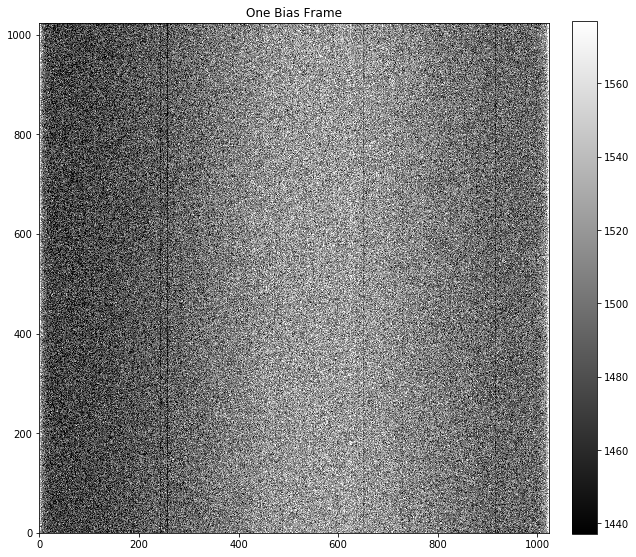

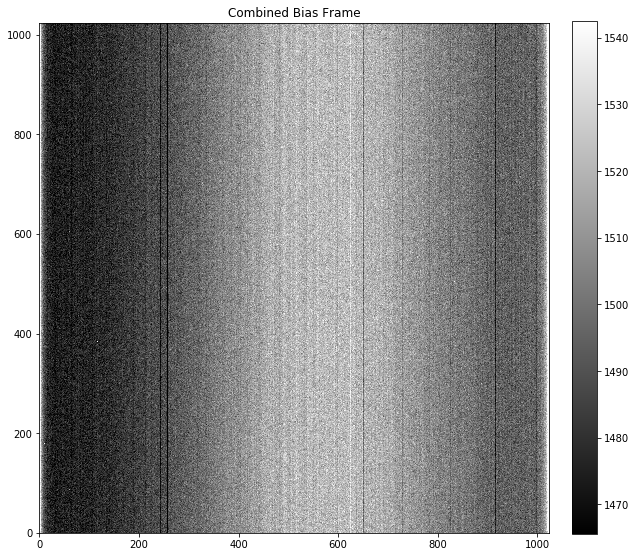

In [20]:
show_image(bias_data[0,:,:],cmap='gray')
plt.title('One Bias Frame')

show_image(combined_bias,cmap='gray')
plt.title('Combined Bias Frame')

Notice how the combined bias frame looks less grainy. That is because the graininess was due to read noise, which is reduced when taking a median combination of multiple frames. 

Next we will write out the median-combined bias frame so that we can access it later.

In [21]:
# Write out the combined bias file

# First read in the header from one of the bias files, and add a comment to say that this is a combined file
hdr = fits.getheader('Cal_data/CalR-0001Bias.fit') #<- just read in the header. This saves time and memory
hdr['history'] = 'Median combination bias frame' #<- Add a new keyword, with the given value (just like any other dictionary)

# Create a new HDU object 
hdu = fits.PrimaryHDU(combined_bias,hdr)
hdu.writeto('Reduced_data/combined_bias.fits',overwrite=True)

Now we want to do the same thing for the dark and flat field frames. The procedure is very similar, with two additional considerations:
- We must subtract the bias level from each dark frame before they are median-combined. We want to final combined dark image to only represent the dark current, not the dark current plus the bias level.
- Each flat image must have the bias level subtracted, as well as the dark current. After creating a combined flat field image, we then need to normalize this combined image, which we can do by dividing the image by its median value. 

Lets start with the dark frame. 

> **Q:** The code below gives the basic outline for creating a median-combined, bias subtracted, dark frame. Insert the necessary lines of code to complete this code block. (There are no intentional errors in this code block, just missing pieces of code).

In [22]:
# Now lets do the same for the dark frame, making sure to subtract off the bias

# Read in the dark frames
dark_data = np.zeros((len(data_files['darks']),1024,1024))
for i,file in enumerate(data_files['darks']):
    image = fits.open(file)
    dark_data[i,:,:] = image[0].data-combined_bias#Insert code to input the dark image data, while subtracting off the bias
    image.close() 
    
#Insert code to median combine the dark_data array
combined_dark = np.median(dark_data,axis=0)


# Write out the combined dark file
# First read in the header from one of the dark files, and add a comment to say that this is a combined file
hdr = fits.getheader('Cal_data/CalR-0001Dark.fit')
hdr['history'] = 'Median combination dark frame'

# Create an HDU object from the data and header, and write out the result. 
hdu = fits.PrimaryHDU(combined_dark,hdr)
hdu.writeto('Reduced_data/combined_dark.fits',overwrite=True)


Text(0.5, 1.0, 'Combined Dark')

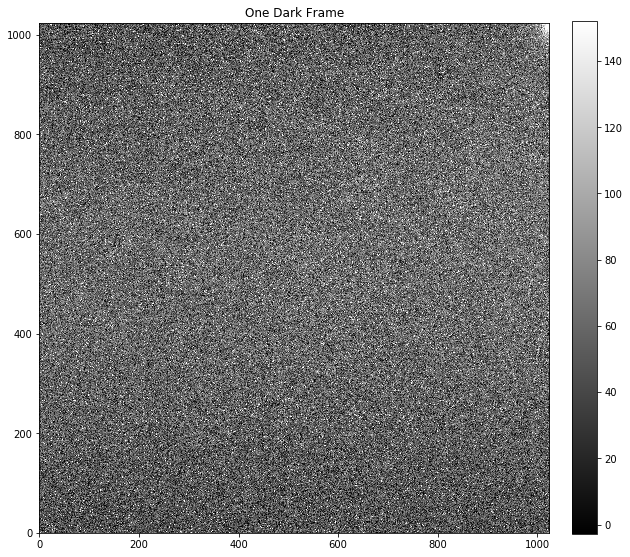

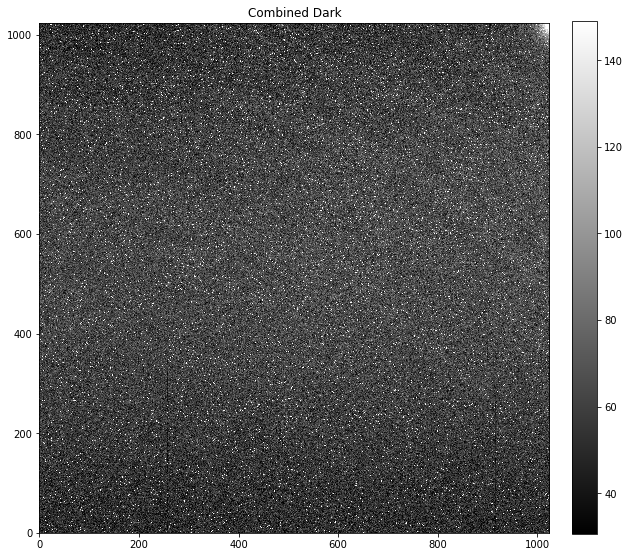

In [24]:
show_image(dark_data[0,:,:],cmap='gray')
plt.title('One Dark Frame')

show_image(combined_dark,cmap='gray')
plt.title('Combined Dark')

> **Q:** Now repeat for the flat field images. Make sure to subtract off both the bias level and the dark current. The dark current must be scaled to the exposure time of the flat field images. To do this, divide the combined dark current image by the exposure time of the dark current image (60 seconds) to get the dark current per second, and then multiply by the exposure time of the flat field image. 

In [25]:

flat_data = np.zeros((len(data_files['Rflats']),1024,1024))
for i,file in enumerate(data_files['Rflats']):
    image = fits.open(file)
    header = image[0].header
    exptime = header['exptime']# Insert code to read in the exposure time from the header
    flat_data[i,:,:] = image[0].data - combined_bias-combined_dark*exptime/60 #Insert code to read the data from image, and subtract both the bias and the scaled dark
    image.close()
    
# Insert code to median combine the flat data, and place the results into a variable called combined_flat
combined_flat = np.median(flat_data,axis=0)
# Next, normalize the flat field image. 
#   Both of the following statements are equivalent (we keep one commented out because we don't want to divide twice)
combined_flat = combined_flat/np.median(combined_flat)
#combined_flat /= np.median(combined_flat)


# First read in the header from one of the flat files, and add a comment to say that this is a combined file
hdr = fits.getheader('Cal_data/CalR-0001R.fit')
hdr['history'] = 'Median combination flat frame'

# Insert code to create a new HDU object, using combined_flat and hdr. 
hdu = fits.PrimaryHDU(combined_flat,hdr)

# Save the result in the Reduced_data directory, as combined_Rflat.fits
hdu.writeto('Reduced_data/combined_Rflat.fits',overwrite=True)

Text(0.5, 1.0, 'Combined Flat')

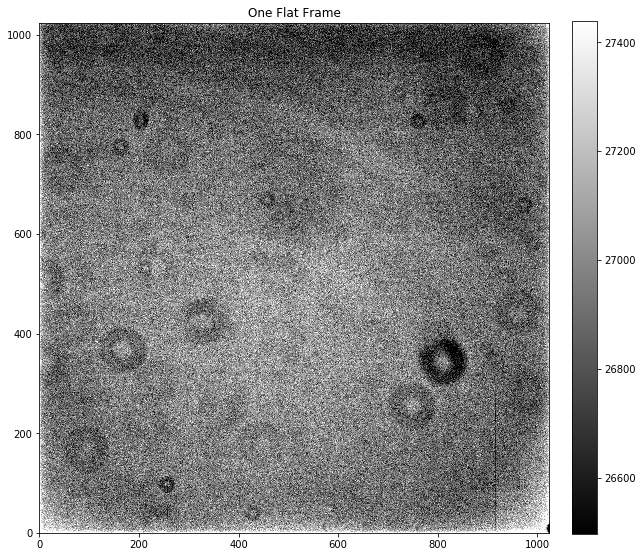

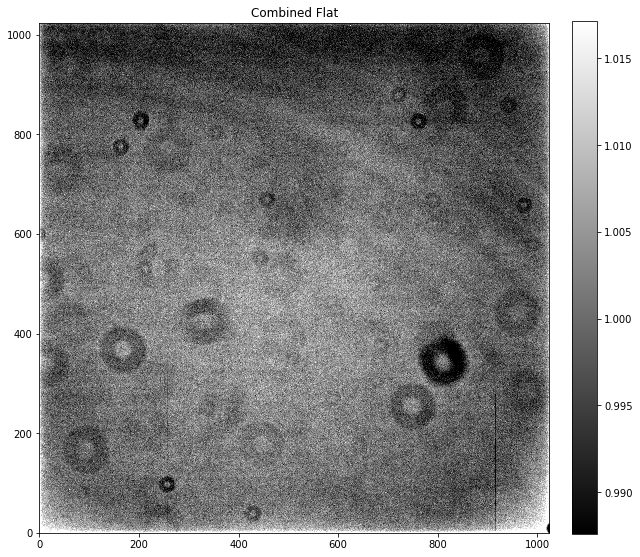

In [26]:
show_image(flat_data[0,:,:],cmap='gray')
plt.title('One Flat Frame')

show_image(combined_flat,cmap='gray')
plt.title('Combined Flat')

Now that we have our master bias, dark, and flat field images, we can apply them to a science image.

> **Q:** Below is the beginning of a function that will read in a science image, and then perform the bias/dark/flat corrections. It takes as inputs the filename of the raw image (as a string), the filename of the output file (a string, and it should be different from the original filename), and the name of the bias, dark, and flat field frames. Building on what you have done earlier, complete this function. 

In [30]:
def process_data(filename,new_filename,bias_file='Reduced_data/combined_bias.fits',dark_file = 'Reduced_data/combined_dark.fits',
                flat_file = 'Reduced_data/combined_flat.fits'):
    
    image = fits.open(filename) #Insert code to read in the raw science fits file.
    data = image[0].data #Insert code to extract the data from image
    hdr = image[0].header#Insert code to read in the header from the science file
    exptime = hdr['exptime']#Insert code to read in the exposure time
    image.close()#Insert code to close the science file
    
    bias_image = fits.open(bias_file)#Insert code to read in bias fits file
    bias_data = bias_image[0].data#Insert code to read in bias data from bias_image
    bias_image.close()#Insert code to close the bias file
    
    dark_image = fits.open(dark_file)#Insert code to read in the dark fits file
    dark_data = dark_image[0].data#Insert code to read in the dark data from dark_image
    dark_image.close()#Insert code to close the dark fits file
    
    flat_image = fits.open(flat_file)#Insert code to read in the flat field image
    flat_data = flat_image[0].data#Insert code to read in the flat data from flat_image
    flat_image.close()#Insert code to close the flat field image
    
    proc_data = (data-bias_data-dark_data/60.*exptime)/flat_data#Insert code to apply the calibration steps to the data
    
    #Insert code to write out the processed data. 
    #Use the header from the original image, but add a keyword that says it has been processed.
    hdr['History'] = 'Bias, Dark, and Flat corrected'
    hdu = fits.PrimaryHDU(proc_data,hdr)
    hdu.writeto(new_filename,overwrite=True)

/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Processed Image')

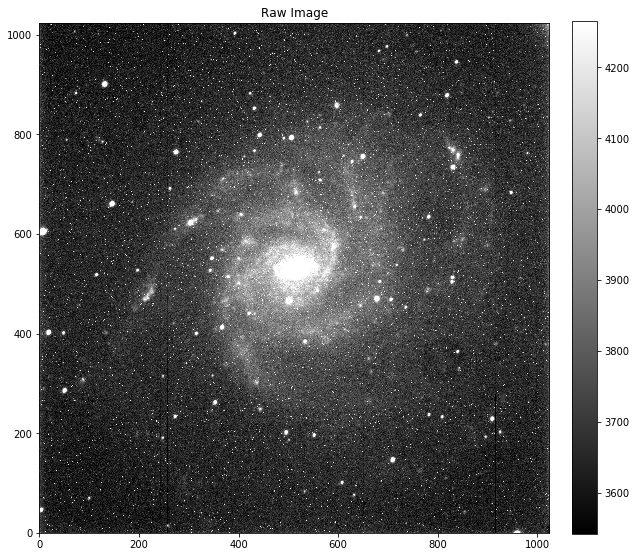

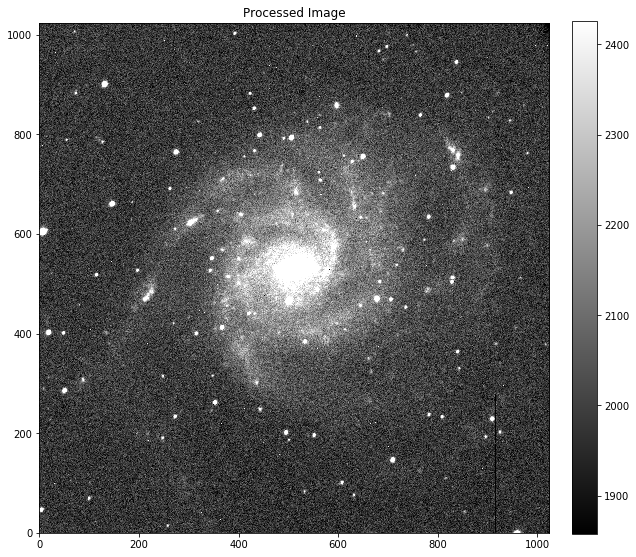

In [31]:
#Test your code using this code block
process_data('M101_MartiC_180-0001.fit','M101_MartiC_180-0001_proc.fits')

old_image = fits.open('M101_MartiC_180-0001.fit')
old_data = old_image[0].data
old_image.close()

new_image = fits.open('M101_MartiC_180-0001_proc.fits')
new_data = new_image[0].data
new_image.close()

show_image(old_data,cmap='gray')
plt.title('Raw Image')

show_image(new_data,cmap='gray')
plt.title('Processed Image')

Here is the list of new code from the beginning of the lab. Fill in each line with the new code, or a description of what the code does.

#### New Code:
- *Open a fits file*: `image = fits.open('mydata.fit')`
- *Get info on the fits file*: `image.info()`
- *Read the data from a fits file into a variable*: `data = image[0].data`
- *Read the header from a fits file into a variable*: `hdr = image[0].header`
- *Access elements of the header*: `hdr['exptime']`
- *Output the shape of a numpy array* `data.shape`
- *Display an image using the show_image function*: `show_image(data,cmap='gray')`
- *Plot a histogram*: `plt.hist(data,1000,histtype='step')`
- *`plt.xlim(value1,value2)`*: Sets the x-axis range
- *Close a fits file*: `image.close()`
- *`np.zeros((dimension1,dimension2,dimension3))`*: Create an array filled with zeros of the given dimension.
- `enumerate`: Returns each element of a list, and the index of that element.
- *Take the median along one dimension of a multi-dimensional array*: `np.median(data,axis=0)`
- *Just read in the header*: `hdr = fits.getheader('mydata.fits')`
- *Add a new element to the header*: `hdr['new_element'] = 'blah'`
- *Create a new fits file*: `hdu=fits.PrimaryHDU(mydata,myhdr)`
- *Write out a fits file*: `hdu.writeto('newfile.fits',overwrite=True)`



**Stop Here** 

Save your ipython notebook, add the names of your group members to the filename, and copy the notebook back to the server in Astro211_S20/Place_Your_Results_Here/Lab4_CCD/

You do not need to copy any of the fits files that you created, just the jupyter notebook.

---
---
---
### Extra

After we have processed a set of data, we want to median combine it, as we did for the dark, bias, and flat field images. 

> **Q:** Write a function that reads in a list of processed science images and a name for the new combined file. Read in each of the processed files, median combine them, and write out the result. Test this function on ??? files. 

In [ ]:
def median_combine_images(list_of_images,new_filename):
    
    total_data = np.array((len(list_of_images),1024,1024))
    for i,file in enumerate(list_of_images):
        image = fits.open(file)
        total_data[i,:,:] = image[0].data
        
    median_image = np.median(total_data,axis=0)
    
    # First read in the header from one of the bias files, and add a comment to say that this is a combined file
    hdr = fits.getheader(list_of_images[0]) 
    hdr['history'] = 'Median combination image' 
    
    # Create a new HDU object 
    hdu = fits.PrimaryHDU(median_image,hdr)
    hdu.writeto(new_filename,overwrite=True)

